In [1]:
import torch
import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp
import matplotlib.pyplot as plt
import numpy as np
import arviz

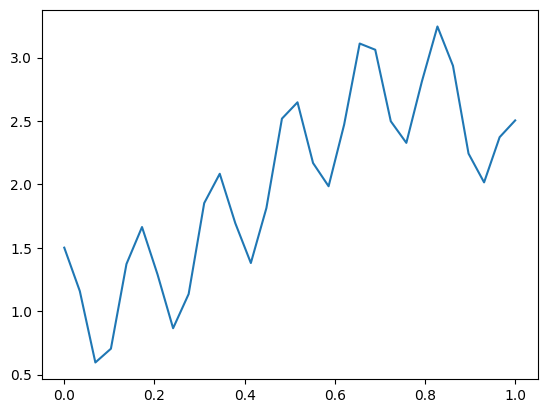

In [2]:
# Seed for reproducibility
pyro.set_rng_seed(1028)
pyro.clear_param_store()

# Generate the dataset (30 points)
l = 30
x_full = torch.linspace(0, 1, l)
g = lambda x: -(torch.sin(6 * torch.pi * x))**2 + 6 * x**2 - 5 * x**4 + 3 / 2
y_full = g(x_full) + torch.normal(0, 0.01, size=(l,))

# Partition data into 20 training and 10 testing points
train_idx = torch.randperm(l)[:20]
test_idx = torch.tensor([i for i in range(l) if i not in train_idx])
x_train, y_train = x_full[train_idx], y_full[train_idx]
x_test, y_test = x_full[test_idx], y_full[test_idx]


plt.plot(x_full, y_full)

In [4]:
############ Part 1 #############
# Define the Gaussian Periodic kernel with priors
kernel = gp.kernels.Periodic(input_dim=1)
kernel.lengthscale = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.1), torch.tensor(3.0)))
kernel.variance = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.1), torch.tensor(8.0)))
kernel.period = torch.tensor(0.2, requires_grad=False)


gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=torch.tensor(0.01))
#print(kernel.period)


tensor(0.2000, grad_fn=<AddBackward0>)


In [5]:
def log_p_y_theta(gp_model, lengthscale, variance, noise=0.01):
    """
    Compute the log-likelihood p(y, θ | X) for given hyperparameters.

    Args:
        gp_model: Pyro GP model.
        lengthscale: Lengthscale of the kernel.
        variance: Variance of the kernel.
        noise: Noise level (default: 0.01).

    Returns:
        Log-likelihood p(y, θ | X).
    """
    # Explicitly define the priors
    lengthscale_prior = dist.Uniform(torch.tensor(0.1), torch.tensor(3.0))
    variance_prior = dist.Uniform(torch.tensor(0.1), torch.tensor(8.0))

    kernel = gp_model.kernel
    kernel.lengthscale = lengthscale
    kernel.variance = variance
    #print(f"Current Hyperparameters: lengthscale={lengthscale}, variance={variance}, period={kernel.period}, noise={noise}")


    # Compute log prior probabilities
    prior_log_prob = (
        lengthscale_prior.log_prob(lengthscale).sum() +
        variance_prior.log_prob(variance).sum()
    )

    # Compute the kernel matrix and log-likelihood contribution
    K = gp_model.kernel(gp_model.X) + torch.eye(len(gp_model.X)) * noise
    L = torch.linalg.cholesky(K)
    alpha = torch.cholesky_solve(gp_model.y.unsqueeze(-1), L)
    log_det = torch.sum(torch.log(torch.diag(L)))
    quad_form = torch.matmul(gp_model.y.unsqueeze(0), alpha)

    n = len(gp_model.X)
    likelihood_log_prob = -0.5 * (quad_form + log_det + n * torch.log(torch.tensor(2.0 * np.pi)))

    # Sum priors and likelihood
    total_log_prob = prior_log_prob + likelihood_log_prob.squeeze()
    return total_log_prob

# Test log_p_y_theta
print("Log p(y, theta | X):", log_p_y_theta(gpr, gpr.kernel.lengthscale, gpr.kernel.variance))


Log p(y, theta | X): tensor(-478.3333, grad_fn=<AddBackward0>)


In [9]:
################# Part 2 ###################
## Maximum a-posteriori (MAP) estimate of hyperparameters

# Define trainable hyperparameters and inital parameters
lengthscale = torch.tensor(1.0, requires_grad=True)  
variance = torch.tensor(1.0, requires_grad=True)    
noise = 0.01 

#Stochastic gradient descent
optimizer = torch.optim.Adam([lengthscale, variance], lr=0.01)

def train_gp_model(gp_model, num_steps=2000):
    for step in range(num_steps):
        optimizer.zero_grad()
        
        loss = -log_p_y_theta(gp_model, lengthscale, variance, noise=noise)
        loss.backward()  
        optimizer.step()  
        
        # Print progress every 100 steps
        if step % 100 == 0 or step == num_steps - 1:
            print(
                f"Step {step}: Loss = {loss.item():.4f}, "
                f"Lengthscale = {lengthscale.item():.4f}, Variance = {variance.item():.4f}"
            )


train_gp_model(gpr)

# Estimated MAP kernel parameters
lengthscale_map = lengthscale.item()
variance_map = variance.item()
period_map = kernel.period.item()
MAP_est = [lengthscale_map, variance_map, period_map]

#Period does not always stay exactly the fixed value of 0.2? Maybe pyro overwrites it somewhere
print(f"MAP Estimates:\nLengthscale: {lengthscale_map:.4f}\nVariance: {variance_map:.4f}\nPeriod: {period_map:.4f}")


Step 0: Loss = 567.0932, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 63.3925, Lengthscale = 0.2456, Variance = 1.7252
Step 200: Loss = 61.9285, Lengthscale = 0.2313, Variance = 1.9252
Step 300: Loss = 60.9343, Lengthscale = 0.2335, Variance = 2.1266
Step 400: Loss = 60.1713, Lengthscale = 0.2356, Variance = 2.3201
Step 500: Loss = 59.5811, Lengthscale = 0.2374, Variance = 2.5032
Step 600: Loss = 59.1160, Lengthscale = 0.2391, Variance = 2.6760
Step 700: Loss = 58.7414, Lengthscale = 0.2407, Variance = 2.8395
Step 800: Loss = 58.4351, Lengthscale = 0.2422, Variance = 2.9947
Step 900: Loss = 58.1800, Lengthscale = 0.2435, Variance = 3.1426
Step 1000: Loss = 57.9653, Lengthscale = 0.2448, Variance = 3.2842
Step 1100: Loss = 57.7822, Lengthscale = 0.2460, Variance = 3.4200
Step 1200: Loss = 57.6242, Lengthscale = 0.2471, Variance = 3.5508
Step 1300: Loss = 57.4874, Lengthscale = 0.2482, Variance = 3.6771
Step 1400: Loss = 57.3669, Lengthscale = 0.2492, Variance = 3.7992
Step 1

In [10]:
# Evaluate the posterior log-likelihood

def posterior_log_likelihood_map(x_train, y_train, x_test, y_test, kernel, noise, est_params):
    """
    Compute the posterior log-likelihood of the test set using MAP estimates.

    Args:
        x_train: Training inputs.
        y_train: Training outputs.
        x_test: Test inputs.
        y_test: Test outputs.
        kernel: Kernel function with MAP hyperparameters.
        noise: Noise variance (MAP estimate).

    Returns:
        Posterior log-likelihood for the test set.
    """
    
    kernel.lengthscale = est_params[0]
    kernel.variance = est_params[1]
    kernel.period = est_params[2]

    # Compute covariance matrices using MAP parameters
    K_train = kernel(x_train) + torch.eye(len(x_train)) * noise
    K_s = kernel(x_train, x_test)
    K_ss = kernel(x_test) + torch.eye(len(x_test)) * noise

    # Compute posterior predictive mean and covariance
    L = torch.linalg.cholesky(K_train)
    alpha = torch.cholesky_solve(y_train.unsqueeze(-1), L)
    mu_test = torch.matmul(K_s.T, alpha).squeeze(-1)  # Posterior mean

    v = torch.linalg.solve(L, K_s)
    cov_test = K_ss - torch.matmul(v.T, v)  # Posterior covariance

    # Gaussian log-likelihood for the test set
    residuals = y_test - mu_test
    L_test = torch.linalg.cholesky(cov_test + 1e-6 * torch.eye(len(x_test)))  # Add jitter for stability
    quad_form = torch.matmul(residuals.unsqueeze(0), torch.cholesky_solve(residuals.unsqueeze(-1), L_test))
    log_det = torch.sum(torch.log(torch.diag(L_test)))
    n_test = len(y_test)

    log_likelihood = -0.5 * (quad_form + log_det + n_test * torch.log(torch.tensor(2.0 * np.pi)))
    return log_likelihood.item()


# Example Usage
#test_est2 = [0.2, 4.7, 0.2]
log_likelihood_test = posterior_log_likelihood_map(x_train, y_train, x_test, y_test, gpr.kernel, noise=0.01, est_params=MAP_est)
print(f"Posterior Log-Likelihood (Test Set) using MAP: {log_likelihood_test:.4f}")


Posterior Log-Likelihood (Test Set) using MAP: -10.5476


In [11]:
###################### Part 3 #####################
# Using NUTS to MCMC sample from the posterior

#Redefining the kernel again making sure its the same as in the first exercises and pyro has not overwritten it
kernel = gp.kernels.Periodic(input_dim=1)
kernel.lengthscale = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.1), torch.tensor(3.0)))
kernel.variance = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.1), torch.tensor(8.0)))
kernel.period = torch.tensor(0.2, requires_grad=False)
gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=torch.tensor(0.01))

n_chains = 4
n_warmup = 500
n_samples_per_chain = 5000
n_samples = n_chains * n_samples_per_chain

nuts_kernel = pyro.infer.mcmc.NUTS(gpr.model)

mcmc = pyro.infer.mcmc.MCMC(nuts_kernel, warmup_steps = n_warmup, num_samples = n_samples_per_chain, num_chains = n_chains)

mcmc.run()

samples = mcmc.get_samples()

Warmup [1]:   0%|          | 0/5500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/5500 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/5500 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/5500 [00:00, ?it/s]

/Users/clararosengaardgroth/miniconda3/lib/python3.12/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


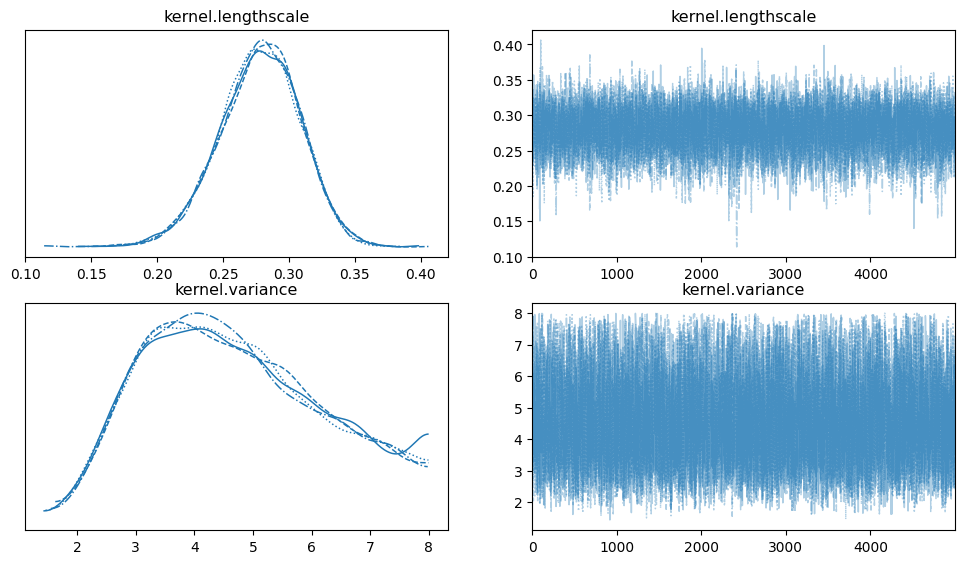

In [12]:
# Diagnostics
arviz_data = arviz.from_pyro(mcmc, num_chains = n_chains)
axes = arviz.plot_trace(arviz_data, figsize = (12, 6.5))

In [13]:
arviz.summary(arviz_data, hdi_prob = 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kernel.lengthscale,0.278,0.031,0.218,0.337,0.000,0.000,7347.0,6758.0,1.0
kernel.variance,4.678,1.486,2.231,7.636,0.019,0.014,6503.0,5361.0,1.0


In [14]:
##################### Part 4 ####################

#Evaluate the posterior log likelihood of the test data usig the last 500 samples in the chain as estimates for params
last_500_lengthscale = samples["kernel.lengthscale"][-500:]
last_500_variance = samples["kernel.variance"][-500:]


lengthscale_mean = torch.mean(last_500_lengthscale)
variance_mean = torch.mean(last_500_variance)
#print(kernel.period)

mcmc_est = [lengthscale_mean, variance_mean, kernel.period]
log_likelihood_test = posterior_log_likelihood_map(x_train, y_train, x_test, y_test, gpr.kernel, noise=0.01, est_params=mcmc_est)
print(f"Posterior Log-Likelihood (Test Set) using MCMC: {log_likelihood_test:.4f} \nMCMC lengthscale est: {lengthscale_mean:.4f} \nMCMC variance est: {variance_mean:.4f}")

Posterior Log-Likelihood (Test Set) using MCMC: -10.9758 
MCMC lengthscale est: 0.2739 
MCMC variance est: 4.4929


In [15]:
############# Part 5 ################

# Repeat for 20 different datasets

def generate_dataset(l=30, noise_std=0.01, train_size=20, test_size=10):
    """
    Generate a dataset with randomized train-test split.

    Args:
        l (int): Total number of data points.
        noise_std (float): Standard deviation of the noise.
        train_size (int): Number of training points.
        test_size (int): Number of testing points.

    Returns:
        x_train (torch.Tensor): Training inputs.
        y_train (torch.Tensor): Training outputs.
        x_test (torch.Tensor): Test inputs.
        y_test (torch.Tensor): Test outputs.
    """
    # Generate the full dataset
    x_full = torch.linspace(0, 1, l)
    g = lambda x: -(torch.sin(6 * torch.pi * x))**2 + 6 * x**2 - 5 * x**4 + 3 / 2
    y_full = g(x_full) + torch.normal(0, noise_std, size=(l,))

    # Randomly partition into training and testing points
    train_idx = torch.randperm(l)[:train_size]
    test_idx = torch.tensor([i for i in range(l) if i not in train_idx])
    x_train, y_train = x_full[train_idx], y_full[train_idx]
    x_test, y_test = x_full[test_idx], y_full[test_idx]

    return x_train, y_train, x_test, y_test

# Generate 20 datasets
datasets = []
for i in range(20):
    x_train, y_train, x_test, y_test = generate_dataset()
    datasets.append((x_train, y_train, x_test, y_test))


First Dataset:
x_train:
tensor([0.1034, 0.8621, 0.5172, 0.0000, 0.4138, 1.0000, 0.1724, 0.2414, 0.9310,
        0.3448, 0.8966, 0.6207, 0.0345, 0.9655, 0.8276, 0.4483, 0.6897, 0.0690,
        0.3103, 0.7241])
y_train:
tensor([0.7060, 2.9234, 2.6449, 1.5103, 1.3995, 2.5002, 1.6616, 0.8599, 2.0065,
        2.1038, 2.2003, 2.4937, 1.1385, 2.3767, 3.2528, 1.8328, 3.0471, 0.6009,
        1.8410, 2.4952])
x_test:
tensor([0.1379, 0.2069, 0.2759, 0.3793, 0.4828, 0.5517, 0.5862, 0.6552, 0.7586,
        0.7931])
y_test:
tensor([1.3538, 1.2800, 1.1353, 1.6757, 2.5233, 2.1739, 1.9635, 3.0966, 2.3402,
        2.8158])


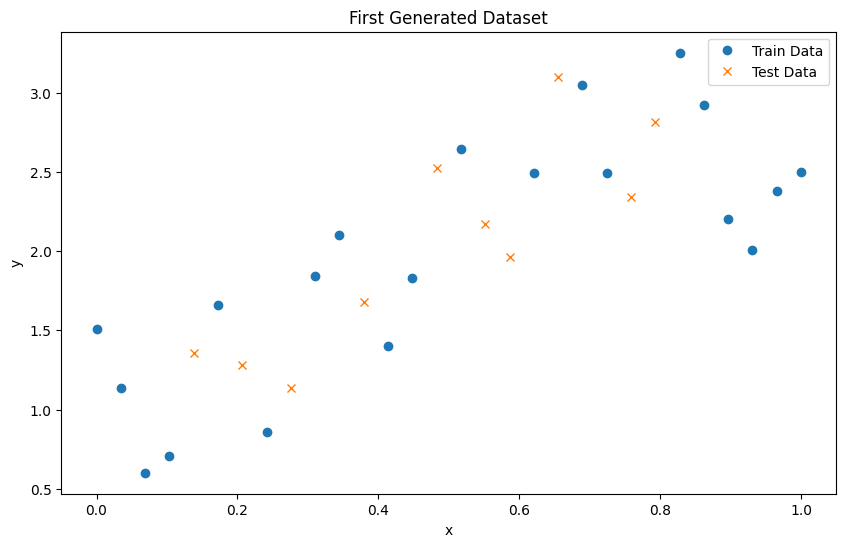

In [16]:
# Access the first dataset
first_dataset = datasets[0]

# Unpack the dataset
x_train, y_train, x_test, y_test = first_dataset

# Print the data
print("First Dataset:")
print(f"x_train:\n{x_train}")
print(f"y_train:\n{y_train}")
print(f"x_test:\n{x_test}")
print(f"y_test:\n{y_test}")

# Optional: Visualize the dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_train.numpy(), 'o', label='Train Data')
plt.plot(x_test.numpy(), y_test.numpy(), 'x', label='Test Data')
plt.title("First Generated Dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


In [17]:
# Initialize lists to store results
sgd_likelihoods = []
sgd_params = []
mcmc_likelihoods = []
mcmc_params = []

#kernel = gp.kernels.Periodic(input_dim=1)
#kernel.lengthscale = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.1), torch.tensor(3.0)))
#kernel.variance = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.1), torch.tensor(8.0)))
#kernel.period = torch.tensor(0.2, requires_grad=False)

# Process 20 datasets
for dataset_idx, (x_train, y_train, x_test, y_test) in enumerate(datasets):
    print(f"Processing Dataset {dataset_idx + 1}...")

    # Part 2: Perform SGD for MAP estimation
    kernel = gp.kernels.Periodic(input_dim=1)
    kernel.lengthscale = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.1), torch.tensor(3.0)))
    kernel.variance = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.1), torch.tensor(8.0)))
    kernel.period = torch.tensor(0.2, requires_grad=False)
    gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=torch.tensor(0.01))

    lengthscale = torch.tensor(1.0, requires_grad=True)
    variance = torch.tensor(1.0, requires_grad=True)
    optimizer = torch.optim.Adam([lengthscale, variance], lr=0.01)
    train_gp_model(gpr, num_steps=2000)

    sgd_params.append([lengthscale.item(), variance.item(), kernel.period.item()])
    sgd_likelihoods.append(
        posterior_log_likelihood_map(x_train, y_train, x_test, y_test, kernel, noise=0.01, est_params=sgd_params[-1])
    )

    # Part 3: Perform MCMC sampling
    kernel = gp.kernels.Periodic(input_dim=1)
    kernel.lengthscale = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.1), torch.tensor(3.0)))
    kernel.variance = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.1), torch.tensor(8.0)))
    kernel.period = torch.tensor(0.2, requires_grad=False)
    gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=torch.tensor(0.01))

    nuts_kernel = pyro.infer.mcmc.NUTS(gpr.model)
    mcmc = pyro.infer.mcmc.MCMC(nuts_kernel, warmup_steps=500, num_samples=2000, num_chains=2)
    mcmc.run()

    samples = mcmc.get_samples()
    last_500_lengthscale = samples["kernel.lengthscale"][-500:]
    last_500_variance = samples["kernel.variance"][-500:]
    mcmc_params.append([
        torch.mean(last_500_lengthscale).item(),
        torch.mean(last_500_variance).item(),
        kernel.period.item()
    ])
    mcmc_likelihoods.append(
        posterior_log_likelihood_map(x_train, y_train, x_test, y_test, kernel, noise=0.01, est_params=mcmc_params[-1])
    )

# Summary Statistics
sgd_mean = torch.mean(torch.tensor(sgd_likelihoods)).item()
sgd_std = torch.std(torch.tensor(sgd_likelihoods)).item()
mcmc_mean = torch.mean(torch.tensor(mcmc_likelihoods)).item()
mcmc_std = torch.std(torch.tensor(mcmc_likelihoods)).item()

print(f"SGD Posterior Log-Likelihoods: Mean = {sgd_mean:.4f}, Std = {sgd_std:.4f}")
print(f"MCMC Posterior Log-Likelihoods: Mean = {mcmc_mean:.4f}, Std = {mcmc_std:.4f}")


Processing Dataset 1...
Step 0: Loss = 520.9742, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 62.3559, Lengthscale = 0.2245, Variance = 1.7854
Step 200: Loss = 61.0730, Lengthscale = 0.2280, Variance = 2.0056
Step 300: Loss = 60.0884, Lengthscale = 0.2301, Variance = 2.2261
Step 400: Loss = 59.3529, Lengthscale = 0.2320, Variance = 2.4350
Step 500: Loss = 58.7956, Lengthscale = 0.2337, Variance = 2.6306
Step 600: Loss = 58.3622, Lengthscale = 0.2352, Variance = 2.8139
Step 700: Loss = 58.0181, Lengthscale = 0.2366, Variance = 2.9862
Step 800: Loss = 57.7392, Lengthscale = 0.2379, Variance = 3.1490
Step 900: Loss = 57.5085, Lengthscale = 0.2391, Variance = 3.3034
Step 1000: Loss = 57.3163, Lengthscale = 0.2402, Variance = 3.4506
Step 1100: Loss = 57.1528, Lengthscale = 0.2413, Variance = 3.5913
Step 1200: Loss = 57.0139, Lengthscale = 0.2423, Variance = 3.7263
Step 1300: Loss = 56.8929, Lengthscale = 0.2432, Variance = 3.8561
Step 1400: Loss = 56.7889, Lengthscale = 0.2441, 

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 2...
Step 0: Loss = 505.8341, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 38.1240, Lengthscale = 0.2525, Variance = 1.7718
Step 200: Loss = 36.9370, Lengthscale = 0.2522, Variance = 1.9815
Step 300: Loss = 36.0112, Lengthscale = 0.2557, Variance = 2.1928
Step 400: Loss = 35.3105, Lengthscale = 0.2589, Variance = 2.3945
Step 500: Loss = 34.7736, Lengthscale = 0.2618, Variance = 2.5843
Step 600: Loss = 34.3530, Lengthscale = 0.2645, Variance = 2.7629
Step 700: Loss = 34.0162, Lengthscale = 0.2669, Variance = 2.9315
Step 800: Loss = 33.7413, Lengthscale = 0.2692, Variance = 3.0913
Step 900: Loss = 33.5132, Lengthscale = 0.2714, Variance = 3.2435
Step 1000: Loss = 33.3212, Lengthscale = 0.2734, Variance = 3.3889
Step 1100: Loss = 33.1577, Lengthscale = 0.2752, Variance = 3.5284
Step 1200: Loss = 33.0169, Lengthscale = 0.2770, Variance = 3.6626
Step 1300: Loss = 32.8946, Lengthscale = 0.2787, Variance = 3.7922
Step 1400: Loss = 32.7876, Lengthscale = 0.2803, 

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 3...
Step 0: Loss = 391.6838, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 60.7341, Lengthscale = 0.2355, Variance = 1.7361
Step 200: Loss = 59.5445, Lengthscale = 0.2475, Variance = 1.9657
Step 300: Loss = 58.7299, Lengthscale = 0.2494, Variance = 2.1905
Step 400: Loss = 58.1438, Lengthscale = 0.2511, Variance = 2.3994
Step 500: Loss = 57.7122, Lengthscale = 0.2527, Variance = 2.5922
Step 600: Loss = 57.3845, Lengthscale = 0.2541, Variance = 2.7707
Step 700: Loss = 57.1293, Lengthscale = 0.2554, Variance = 2.9369
Step 800: Loss = 56.9262, Lengthscale = 0.2566, Variance = 3.0925
Step 900: Loss = 56.7616, Lengthscale = 0.2577, Variance = 3.2389
Step 1000: Loss = 56.6259, Lengthscale = 0.2587, Variance = 3.3772
Step 1100: Loss = 56.5134, Lengthscale = 0.2597, Variance = 3.5083
Step 1200: Loss = 56.4187, Lengthscale = 0.2605, Variance = 3.6331
Step 1300: Loss = 56.3379, Lengthscale = 0.2614, Variance = 3.7522
Step 1400: Loss = 56.2689, Lengthscale = 0.2622, 

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 4...
Step 0: Loss = 493.8483, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 62.6527, Lengthscale = 0.2195, Variance = 1.7851
Step 200: Loss = 61.2921, Lengthscale = 0.2287, Variance = 2.0161
Step 300: Loss = 60.2918, Lengthscale = 0.2311, Variance = 2.2453
Step 400: Loss = 59.5557, Lengthscale = 0.2333, Variance = 2.4609
Step 500: Loss = 59.0031, Lengthscale = 0.2353, Variance = 2.6616
Step 600: Loss = 58.5763, Lengthscale = 0.2370, Variance = 2.8491
Step 700: Loss = 58.2385, Lengthscale = 0.2386, Variance = 3.0250
Step 800: Loss = 57.9662, Lengthscale = 0.2401, Variance = 3.1908
Step 900: Loss = 57.7425, Lengthscale = 0.2414, Variance = 3.3479
Step 1000: Loss = 57.5550, Lengthscale = 0.2427, Variance = 3.4974
Step 1100: Loss = 57.3964, Lengthscale = 0.2438, Variance = 3.6402
Step 1200: Loss = 57.2615, Lengthscale = 0.2449, Variance = 3.7770
Step 1300: Loss = 57.1459, Lengthscale = 0.2460, Variance = 3.9085
Step 1400: Loss = 57.0442, Lengthscale = 0.2469, 

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 5...
Step 0: Loss = 460.7606, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 62.5143, Lengthscale = 0.2624, Variance = 1.7536
Step 200: Loss = 61.0763, Lengthscale = 0.2571, Variance = 1.9924
Step 300: Loss = 60.0428, Lengthscale = 0.2591, Variance = 2.2253
Step 400: Loss = 59.2902, Lengthscale = 0.2610, Variance = 2.4431
Step 500: Loss = 58.7293, Lengthscale = 0.2627, Variance = 2.6453
Step 600: Loss = 58.2974, Lengthscale = 0.2642, Variance = 2.8337
Step 700: Loss = 57.9560, Lengthscale = 0.2657, Variance = 3.0102
Step 800: Loss = 57.6812, Lengthscale = 0.2670, Variance = 3.1764
Step 900: Loss = 57.4561, Lengthscale = 0.2682, Variance = 3.3338
Step 1000: Loss = 57.2683, Lengthscale = 0.2694, Variance = 3.4835
Step 1100: Loss = 57.1105, Lengthscale = 0.2705, Variance = 3.6264
Step 1200: Loss = 56.9745, Lengthscale = 0.2715, Variance = 3.7632
Step 1300: Loss = 56.8586, Lengthscale = 0.2724, Variance = 3.8948
Step 1400: Loss = 56.7572, Lengthscale = 0.2734, 

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 6...
Step 0: Loss = 346.4990, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 63.1663, Lengthscale = 0.1930, Variance = 1.8300
Step 200: Loss = 61.7531, Lengthscale = 0.2000, Variance = 2.1208
Step 300: Loss = 60.8057, Lengthscale = 0.2053, Variance = 2.3918
Step 400: Loss = 60.1525, Lengthscale = 0.2098, Variance = 2.6382
Step 500: Loss = 59.6806, Lengthscale = 0.2136, Variance = 2.8630
Step 600: Loss = 59.3263, Lengthscale = 0.2171, Variance = 3.0699
Step 700: Loss = 59.0515, Lengthscale = 0.2203, Variance = 3.2622
Step 800: Loss = 58.8326, Lengthscale = 0.2231, Variance = 3.4421
Step 900: Loss = 58.6545, Lengthscale = 0.2257, Variance = 3.6116
Step 1000: Loss = 58.5074, Lengthscale = 0.2281, Variance = 3.7721
Step 1100: Loss = 58.3842, Lengthscale = 0.2303, Variance = 3.9247
Step 1200: Loss = 58.2793, Lengthscale = 0.2324, Variance = 4.0705
Step 1300: Loss = 58.1904, Lengthscale = 0.2343, Variance = 4.2101
Step 1400: Loss = 58.1126, Lengthscale = 0.2361, 

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 7...
Step 0: Loss = 288.8347, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 59.2321, Lengthscale = 0.2963, Variance = 1.7173
Step 200: Loss = 57.8976, Lengthscale = 0.3118, Variance = 1.9829
Step 300: Loss = 57.0279, Lengthscale = 0.3158, Variance = 2.2345
Step 400: Loss = 56.4250, Lengthscale = 0.3193, Variance = 2.4639
Step 500: Loss = 55.9888, Lengthscale = 0.3224, Variance = 2.6735
Step 600: Loss = 55.6607, Lengthscale = 0.3251, Variance = 2.8667
Step 700: Loss = 55.4064, Lengthscale = 0.3275, Variance = 3.0462
Step 800: Loss = 55.2028, Lengthscale = 0.3297, Variance = 3.2141
Step 900: Loss = 55.0395, Lengthscale = 0.3318, Variance = 3.3722
Step 1000: Loss = 54.9030, Lengthscale = 0.3336, Variance = 3.5218
Step 1100: Loss = 54.7889, Lengthscale = 0.3354, Variance = 3.6641
Step 1200: Loss = 54.6930, Lengthscale = 0.3370, Variance = 3.7998
Step 1300: Loss = 54.6103, Lengthscale = 0.3385, Variance = 3.9298
Step 1400: Loss = 54.5391, Lengthscale = 0.3399, 

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 8...
Step 0: Loss = 510.9583, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 61.2494, Lengthscale = 0.2522, Variance = 1.7636
Step 200: Loss = 60.1494, Lengthscale = 0.2383, Variance = 1.9574
Step 300: Loss = 59.3949, Lengthscale = 0.2401, Variance = 2.1524
Step 400: Loss = 58.8166, Lengthscale = 0.2423, Variance = 2.3398
Step 500: Loss = 58.3712, Lengthscale = 0.2442, Variance = 2.5167
Step 600: Loss = 58.0225, Lengthscale = 0.2460, Variance = 2.6832
Step 700: Loss = 57.7440, Lengthscale = 0.2477, Variance = 2.8401
Step 800: Loss = 57.5181, Lengthscale = 0.2492, Variance = 2.9885
Step 900: Loss = 57.3316, Lengthscale = 0.2506, Variance = 3.1292
Step 1000: Loss = 57.1766, Lengthscale = 0.2519, Variance = 3.2632
Step 1100: Loss = 57.0453, Lengthscale = 0.2531, Variance = 3.3911
Step 1200: Loss = 56.9333, Lengthscale = 0.2542, Variance = 3.5136
Step 1300: Loss = 56.8379, Lengthscale = 0.2553, Variance = 3.6311
Step 1400: Loss = 56.7545, Lengthscale = 0.2563, 

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 9...
Step 0: Loss = 413.1229, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 62.0941, Lengthscale = 0.2593, Variance = 1.7631
Step 200: Loss = 60.8227, Lengthscale = 0.2595, Variance = 2.0035
Step 300: Loss = 59.8979, Lengthscale = 0.2620, Variance = 2.2374
Step 400: Loss = 59.2304, Lengthscale = 0.2642, Variance = 2.4551
Step 500: Loss = 58.7353, Lengthscale = 0.2661, Variance = 2.6565
Step 600: Loss = 58.3576, Lengthscale = 0.2678, Variance = 2.8436
Step 700: Loss = 58.0619, Lengthscale = 0.2694, Variance = 3.0183
Step 800: Loss = 57.8238, Lengthscale = 0.2708, Variance = 3.1824
Step 900: Loss = 57.6293, Lengthscale = 0.2721, Variance = 3.3373
Step 1000: Loss = 57.4702, Lengthscale = 0.2733, Variance = 3.4841
Step 1100: Loss = 57.3357, Lengthscale = 0.2744, Variance = 3.6239
Step 1200: Loss = 57.2205, Lengthscale = 0.2755, Variance = 3.7574
Step 1300: Loss = 57.1231, Lengthscale = 0.2765, Variance = 3.8853
Step 1400: Loss = 57.0388, Lengthscale = 0.2774, 

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 10...
Step 0: Loss = 414.5899, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 61.1527, Lengthscale = 0.2676, Variance = 1.7082
Step 200: Loss = 59.7203, Lengthscale = 0.2809, Variance = 1.9445
Step 300: Loss = 58.7151, Lengthscale = 0.2840, Variance = 2.1763
Step 400: Loss = 57.9888, Lengthscale = 0.2867, Variance = 2.3923
Step 500: Loss = 57.4485, Lengthscale = 0.2892, Variance = 2.5926
Step 600: Loss = 57.0337, Lengthscale = 0.2914, Variance = 2.7790
Step 700: Loss = 56.7060, Lengthscale = 0.2934, Variance = 2.9535
Step 800: Loss = 56.4428, Lengthscale = 0.2952, Variance = 3.1180
Step 900: Loss = 56.2268, Lengthscale = 0.2969, Variance = 3.2737
Step 1000: Loss = 56.0458, Lengthscale = 0.2985, Variance = 3.4219
Step 1100: Loss = 55.8935, Lengthscale = 0.2999, Variance = 3.5634
Step 1200: Loss = 55.7619, Lengthscale = 0.3013, Variance = 3.6991
Step 1300: Loss = 55.6512, Lengthscale = 0.3026, Variance = 3.8296
Step 1400: Loss = 55.5533, Lengthscale = 0.3038,

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 11...
Step 0: Loss = 355.7970, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 37.8578, Lengthscale = 0.2344, Variance = 1.6990
Step 200: Loss = 36.4444, Lengthscale = 0.2432, Variance = 1.9413
Step 300: Loss = 35.4428, Lengthscale = 0.2462, Variance = 2.1760
Step 400: Loss = 34.7266, Lengthscale = 0.2490, Variance = 2.3936
Step 500: Loss = 34.1979, Lengthscale = 0.2514, Variance = 2.5945
Step 600: Loss = 33.7947, Lengthscale = 0.2535, Variance = 2.7809
Step 700: Loss = 33.4783, Lengthscale = 0.2555, Variance = 2.9551
Step 800: Loss = 33.2244, Lengthscale = 0.2573, Variance = 3.1187
Step 900: Loss = 33.0167, Lengthscale = 0.2589, Variance = 3.2734
Step 1000: Loss = 32.8441, Lengthscale = 0.2604, Variance = 3.4203
Step 1100: Loss = 32.6989, Lengthscale = 0.2617, Variance = 3.5604
Step 1200: Loss = 32.5753, Lengthscale = 0.2630, Variance = 3.6944
Step 1300: Loss = 32.4692, Lengthscale = 0.2642, Variance = 3.8230
Step 1400: Loss = 32.3774, Lengthscale = 0.2654,

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 12...
Step 0: Loss = 488.0906, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 64.8943, Lengthscale = 0.2504, Variance = 1.7783
Step 200: Loss = 63.2677, Lengthscale = 0.2605, Variance = 2.0303
Step 300: Loss = 62.1039, Lengthscale = 0.2639, Variance = 2.2763
Step 400: Loss = 61.2626, Lengthscale = 0.2667, Variance = 2.5055
Step 500: Loss = 60.6359, Lengthscale = 0.2692, Variance = 2.7180
Step 600: Loss = 60.1527, Lengthscale = 0.2715, Variance = 2.9161
Step 700: Loss = 59.7711, Lengthscale = 0.2735, Variance = 3.1020
Step 800: Loss = 59.4618, Lengthscale = 0.2755, Variance = 3.2773
Step 900: Loss = 59.2070, Lengthscale = 0.2772, Variance = 3.4436
Step 1000: Loss = 58.9937, Lengthscale = 0.2789, Variance = 3.6022
Step 1100: Loss = 58.8126, Lengthscale = 0.2804, Variance = 3.7540
Step 1200: Loss = 58.6575, Lengthscale = 0.2819, Variance = 3.8998
Step 1300: Loss = 58.5219, Lengthscale = 0.2832, Variance = 4.0404
Step 1400: Loss = 58.4044, Lengthscale = 0.2845,

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 13...
Step 0: Loss = 320.3666, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 36.6807, Lengthscale = 0.2944, Variance = 1.7804
Step 200: Loss = 35.0086, Lengthscale = 0.3138, Variance = 2.0665
Step 300: Loss = 33.9542, Lengthscale = 0.3180, Variance = 2.3368
Step 400: Loss = 33.2234, Lengthscale = 0.3218, Variance = 2.5829
Step 500: Loss = 32.6922, Lengthscale = 0.3251, Variance = 2.8083
Step 600: Loss = 32.2902, Lengthscale = 0.3281, Variance = 3.0165
Step 700: Loss = 31.9759, Lengthscale = 0.3308, Variance = 3.2106
Step 800: Loss = 31.7237, Lengthscale = 0.3332, Variance = 3.3929
Step 900: Loss = 31.5172, Lengthscale = 0.3354, Variance = 3.5653
Step 1000: Loss = 31.3451, Lengthscale = 0.3375, Variance = 3.7292
Step 1100: Loss = 31.1998, Lengthscale = 0.3394, Variance = 3.8857
Step 1200: Loss = 31.0756, Lengthscale = 0.3413, Variance = 4.0358
Step 1300: Loss = 30.9683, Lengthscale = 0.3430, Variance = 4.1801
Step 1400: Loss = 30.8749, Lengthscale = 0.3446,

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 14...
Step 0: Loss = 449.4904, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 37.4394, Lengthscale = 0.2562, Variance = 1.7841
Step 200: Loss = 36.1440, Lengthscale = 0.2618, Variance = 2.0158
Step 300: Loss = 35.1690, Lengthscale = 0.2654, Variance = 2.2457
Step 400: Loss = 34.4497, Lengthscale = 0.2685, Variance = 2.4623
Step 500: Loss = 33.9074, Lengthscale = 0.2712, Variance = 2.6644
Step 600: Loss = 33.4871, Lengthscale = 0.2737, Variance = 2.8535
Step 700: Loss = 33.1533, Lengthscale = 0.2759, Variance = 3.0313
Step 800: Loss = 32.8826, Lengthscale = 0.2779, Variance = 3.1992
Step 900: Loss = 32.6591, Lengthscale = 0.2797, Variance = 3.3587
Step 1000: Loss = 32.4718, Lengthscale = 0.2814, Variance = 3.5107
Step 1100: Loss = 32.3130, Lengthscale = 0.2830, Variance = 3.6562
Step 1200: Loss = 32.1768, Lengthscale = 0.2845, Variance = 3.7960
Step 1300: Loss = 32.0589, Lengthscale = 0.2859, Variance = 3.9306
Step 1400: Loss = 31.9562, Lengthscale = 0.2872,

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 15...
Step 0: Loss = 394.0272, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 37.8109, Lengthscale = 0.2550, Variance = 1.7573
Step 200: Loss = 36.4559, Lengthscale = 0.2480, Variance = 1.9957
Step 300: Loss = 35.5178, Lengthscale = 0.2499, Variance = 2.2269
Step 400: Loss = 34.8408, Lengthscale = 0.2516, Variance = 2.4422
Step 500: Loss = 34.3395, Lengthscale = 0.2532, Variance = 2.6413
Step 600: Loss = 33.9570, Lengthscale = 0.2547, Variance = 2.8261
Step 700: Loss = 33.6576, Lengthscale = 0.2560, Variance = 2.9986
Step 800: Loss = 33.4180, Lengthscale = 0.2572, Variance = 3.1604
Step 900: Loss = 33.2228, Lengthscale = 0.2583, Variance = 3.3131
Step 1000: Loss = 33.0614, Lengthscale = 0.2593, Variance = 3.4577
Step 1100: Loss = 32.9262, Lengthscale = 0.2603, Variance = 3.5952
Step 1200: Loss = 32.8118, Lengthscale = 0.2612, Variance = 3.7265
Step 1300: Loss = 32.7142, Lengthscale = 0.2621, Variance = 3.8521
Step 1400: Loss = 32.6302, Lengthscale = 0.2629,

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 16...
Step 0: Loss = 490.2855, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 36.5321, Lengthscale = 0.2895, Variance = 1.7196
Step 200: Loss = 35.4240, Lengthscale = 0.2824, Variance = 1.9110
Step 300: Loss = 34.5783, Lengthscale = 0.2854, Variance = 2.1052
Step 400: Loss = 33.9250, Lengthscale = 0.2886, Variance = 2.2925
Step 500: Loss = 33.4176, Lengthscale = 0.2915, Variance = 2.4700
Step 600: Loss = 33.0166, Lengthscale = 0.2942, Variance = 2.6378
Step 700: Loss = 32.6937, Lengthscale = 0.2966, Variance = 2.7968
Step 800: Loss = 32.4289, Lengthscale = 0.2988, Variance = 2.9478
Step 900: Loss = 32.2085, Lengthscale = 0.3008, Variance = 3.0918
Step 1000: Loss = 32.0226, Lengthscale = 0.3027, Variance = 3.2296
Step 1100: Loss = 31.8640, Lengthscale = 0.3045, Variance = 3.3619
Step 1200: Loss = 31.7274, Lengthscale = 0.3062, Variance = 3.4893
Step 1300: Loss = 31.6086, Lengthscale = 0.3077, Variance = 3.6123
Step 1400: Loss = 31.5047, Lengthscale = 0.3092,

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 17...
Step 0: Loss = 269.6524, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 59.7877, Lengthscale = 0.2843, Variance = 1.7304
Step 200: Loss = 58.5273, Lengthscale = 0.3000, Variance = 2.0074
Step 300: Loss = 57.7321, Lengthscale = 0.3039, Variance = 2.2656
Step 400: Loss = 57.1912, Lengthscale = 0.3073, Variance = 2.4989
Step 500: Loss = 56.8049, Lengthscale = 0.3102, Variance = 2.7107
Step 600: Loss = 56.5173, Lengthscale = 0.3128, Variance = 2.9047
Step 700: Loss = 56.2964, Lengthscale = 0.3151, Variance = 3.0841
Step 800: Loss = 56.1221, Lengthscale = 0.3172, Variance = 3.2512
Step 900: Loss = 55.9819, Lengthscale = 0.3191, Variance = 3.4078
Step 1000: Loss = 55.8674, Lengthscale = 0.3208, Variance = 3.5555
Step 1100: Loss = 55.7723, Lengthscale = 0.3224, Variance = 3.6952
Step 1200: Loss = 55.6928, Lengthscale = 0.3239, Variance = 3.8280
Step 1300: Loss = 55.6248, Lengthscale = 0.3253, Variance = 3.9545
Step 1400: Loss = 55.5669, Lengthscale = 0.3266,

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 18...
Step 0: Loss = 319.8655, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 64.6533, Lengthscale = 0.2134, Variance = 1.7492
Step 200: Loss = 62.6271, Lengthscale = 0.2305, Variance = 2.0586
Step 300: Loss = 61.3696, Lengthscale = 0.2343, Variance = 2.3423
Step 400: Loss = 60.5147, Lengthscale = 0.2379, Variance = 2.5982
Step 500: Loss = 59.8984, Lengthscale = 0.2411, Variance = 2.8312
Step 600: Loss = 59.4350, Lengthscale = 0.2441, Variance = 3.0459
Step 700: Loss = 59.0732, Lengthscale = 0.2469, Variance = 3.2459
Step 800: Loss = 58.7824, Lengthscale = 0.2495, Variance = 3.4336
Step 900: Loss = 58.5442, Lengthscale = 0.2519, Variance = 3.6112
Step 1000: Loss = 58.3459, Lengthscale = 0.2542, Variance = 3.7802
Step 1100: Loss = 58.1767, Lengthscale = 0.2564, Variance = 3.9418
Step 1200: Loss = 58.0322, Lengthscale = 0.2584, Variance = 4.0969
Step 1300: Loss = 57.9072, Lengthscale = 0.2604, Variance = 4.2465
Step 1400: Loss = 57.7978, Lengthscale = 0.2622,

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 19...
Step 0: Loss = 496.3692, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 61.4087, Lengthscale = 0.2510, Variance = 1.7581
Step 200: Loss = 60.1611, Lengthscale = 0.2563, Variance = 1.9789
Step 300: Loss = 59.2184, Lengthscale = 0.2587, Variance = 2.1989
Step 400: Loss = 58.5215, Lengthscale = 0.2608, Variance = 2.4064
Step 500: Loss = 57.9965, Lengthscale = 0.2627, Variance = 2.6000
Step 600: Loss = 57.5910, Lengthscale = 0.2644, Variance = 2.7808
Step 700: Loss = 57.2695, Lengthscale = 0.2661, Variance = 2.9506
Step 800: Loss = 57.0103, Lengthscale = 0.2675, Variance = 3.1106
Step 900: Loss = 56.7975, Lengthscale = 0.2689, Variance = 3.2622
Step 1000: Loss = 56.6194, Lengthscale = 0.2702, Variance = 3.4064
Step 1100: Loss = 56.4697, Lengthscale = 0.2715, Variance = 3.5440
Step 1200: Loss = 56.3422, Lengthscale = 0.2726, Variance = 3.6759
Step 1300: Loss = 56.2321, Lengthscale = 0.2737, Variance = 3.8026
Step 1400: Loss = 56.1369, Lengthscale = 0.2748,

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

Processing Dataset 20...
Step 0: Loss = 422.9396, Lengthscale = 0.9900, Variance = 1.0100
Step 100: Loss = 64.4621, Lengthscale = 0.2149, Variance = 1.7434
Step 200: Loss = 62.7839, Lengthscale = 0.2238, Variance = 2.0050
Step 300: Loss = 61.6178, Lengthscale = 0.2263, Variance = 2.2556
Step 400: Loss = 60.7910, Lengthscale = 0.2286, Variance = 2.4868
Step 500: Loss = 60.1819, Lengthscale = 0.2307, Variance = 2.6998
Step 600: Loss = 59.7178, Lengthscale = 0.2325, Variance = 2.8974
Step 700: Loss = 59.3533, Lengthscale = 0.2342, Variance = 3.0820
Step 800: Loss = 59.0611, Lengthscale = 0.2357, Variance = 3.2555
Step 900: Loss = 58.8217, Lengthscale = 0.2371, Variance = 3.4196
Step 1000: Loss = 58.6221, Lengthscale = 0.2384, Variance = 3.5755
Step 1100: Loss = 58.4530, Lengthscale = 0.2396, Variance = 3.7243
Step 1200: Loss = 58.3106, Lengthscale = 0.2407, Variance = 3.8669
Step 1300: Loss = 58.1856, Lengthscale = 0.2418, Variance = 4.0038
Step 1400: Loss = 58.0785, Lengthscale = 0.2428,

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

SGD Posterior Log-Likelihoods: Mean = -22.5837, Std = 14.7010
MCMC Posterior Log-Likelihoods: Mean = -28.2010, Std = 18.0417


In [18]:
#sgd_mean = torch.mean(torch.tensor(sgd_likelihoods)).item()
#sgd_std = torch.std(torch.tensor(sgd_likelihoods)).item()
#mcmc_mean = torch.mean(torch.tensor(mcmc_likelihoods)).item()
#mcmc_std = torch.std(torch.tensor(mcmc_likelihoods)).item()
print(sgd_likelihoods)
print(mcmc_likelihoods)

[-10.309972763061523, -37.44474411010742, -11.839803695678711, -10.36152172088623, -11.627473831176758, -9.986238479614258, -33.430564880371094, -11.27620792388916, -12.408159255981445, -18.310691833496094, -35.943809509277344, -12.803786277770996, -56.5210075378418, -38.16166687011719, -34.98420333862305, -45.77730178833008, -28.496456146240234, -10.146676063537598, -11.925104141235352, -9.91932487487793]
[-10.217945098876953, -46.40209197998047, -13.512630462646484, -10.46491813659668, -19.14301300048828, -9.74418830871582, -44.86433029174805, -13.66517162322998, -17.64364242553711, -28.576210021972656, -39.52727508544922, -19.485925674438477, -67.90824127197266, -46.60346221923828, -38.437835693359375, -58.47610855102539, -39.91444778442383, -14.220364570617676, -15.467622756958008, -9.745355606079102]


In [19]:
print(sgd_params)
print(mcmc_params)

[[0.24855948984622955, 4.654353618621826, 0.19999998807907104], [0.28852367401123047, 4.600123405456543, 0.19999998807907104], [0.26608678698539734, 4.460765361785889, 0.19999998807907104], [0.2518410086631775, 4.714415550231934, 0.19999998807907104], [0.2780545949935913, 4.700319766998291, 0.19999998807907104], [0.24507726728916168, 5.057012557983398, 0.19999998807907104], [0.3469909131526947, 4.71594762802124, 0.19999998807907104], [0.26133614778518677, 4.345861911773682, 0.19999998807907104], [0.28199487924575806, 4.658289432525635, 0.19999998807907104], [0.3099970817565918, 4.632155418395996, 0.19999998807907104], [0.2709828019142151, 4.607364177703857, 0.19999998807907104], [0.2912353575229645, 4.912829399108887, 0.19999998807907104], [0.352677583694458, 5.072025299072266, 0.19999998807907104], [0.29375627636909485, 4.763255596160889, 0.19999998807907104], [0.2668958306312561, 4.608428001403809, 0.19999998807907104], [0.3167210519313812, 4.378911018371582, 0.19999998807907104], [0

/var/folders/sw/1gvr93k571d_qm62645m3t5m0000gn/T/ipykernel_49783/1270914719.py:30: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean_f_given_q.flatten().detach().numpy(), covariance_f_given_q.detach().numpy(), size=num_samples)


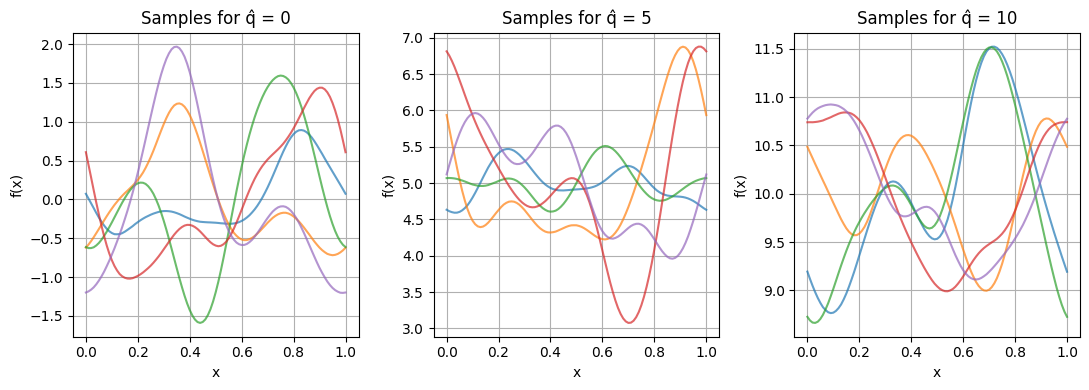

tensor([[0.0050],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0

In [50]:
import torch
import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp
import matplotlib.pyplot as plt
import numpy as np
import arviz

# l and X grid
l = 101 
x = torch.linspace(0, 1, l) 

# Kernel for X
K = gp.kernels.Periodic(input_dim=1)(x)
K.period = 0.2
K.length_scale = 0.2544
K.variance = 4.4632

# weights
w = torch.zeros(l)
w[0] = 1 / (2 * (l - 1))
w[-1] = 1 / (2 * (l - 1))
w[1:-1] = 1 / (l - 1)
w = w[:, np.newaxis]  # Convert to column vector

# Conditional mean and covariance for f|X,q̂
def conditional_gp_samples(q_hat, K, w, num_samples=5):
    mean_f_given_q = K @ w * q_hat / (w.T @ K @ w)
    covariance_f_given_q = K - (K @ w @ w.T @ K) / (w.T @ K @ w)
    samples = np.random.multivariate_normal(mean_f_given_q.flatten().detach().numpy(), covariance_f_given_q.detach().numpy(), size=num_samples)
    return samples

# Plot samples for different values of q̂
q_hats = [0, 5, 10]
num_samples = 5

plt.figure(figsize=(11, 4))
for i, q_hat in enumerate(q_hats):
    samples = conditional_gp_samples(q_hat, K, w, num_samples)
    plt.subplot(1, len(q_hats), i + 1)
    for sample in samples:
        plt.plot(x, sample, alpha=0.7)
    plt.title(f"Samples for q̂ = {q_hat}")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()
print(w)

<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\h'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\h'
/var/folders/sw/1gvr93k571d_qm62645m3t5m0000gn/T/ipykernel_49783/1492225381.py:49: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_star, mu_star, label="Mean ($\mu_{star}$)", color="m")
/var/folders/sw/1gvr93k571d_qm62645m3t5m0000gn/T/ipykernel_49783/1492225381.py:61: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu_{star}$")
/var/folders/sw/1gvr93k571d_qm62645m3t5m0000gn/T/ipykernel_49783/1492225381.py:62: SyntaxWarning: invalid escape sequence '\h'
  plt.title("Posterior Mean with Confidence Band for $f|\hat{q},\\mathcal{D}$")


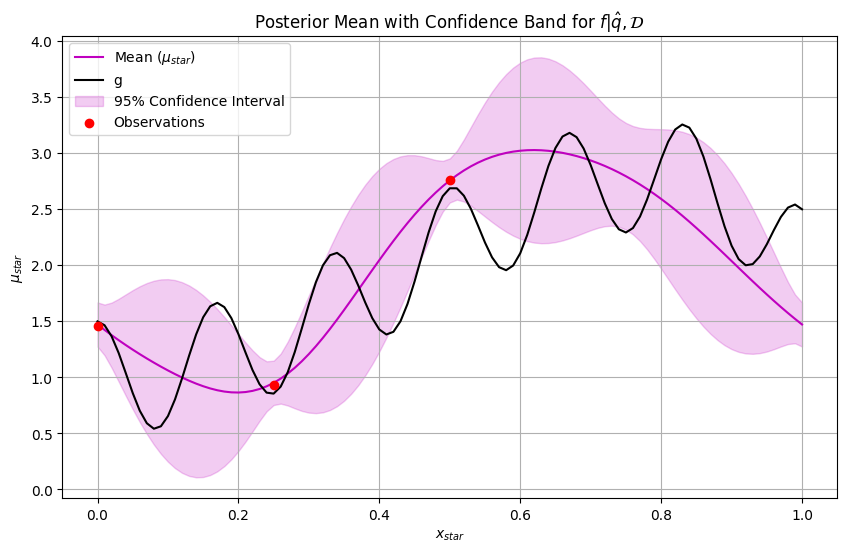

In [39]:
import matplotlib.pyplot as plt
# observations
x_obs = torch.tensor([0,0.25,0.5])
y_obs = torch.tensor([1.46,0.93,2.76])

# Parameters and X* grid
l = 101
q_hat = 2
x_star = torch.linspace(0, 1, l) 

# weights
w = torch.zeros(l)
w[0] = 1 / (2 * (l - 1))
w[-1] = 1 / (2 * (l - 1))
w[1:-1] = 1 / (l - 1)
w = w[:, np.newaxis]

# Kernel for X
K = gp.kernels.Periodic(input_dim=1)(x_star)
K.period = 0.2
K.length_scale = 0.2544
K.variance = 4.4632

# means and covariances 
mu_fq = K @ w * q_hat / (w.T @ K @ w)
cov_fq = K - (K @ w @ w.T @ K) / (w.T @ K @ w)
mu_y = mu_fq[[0,25,50]]
cov_fq_marg = torch.tensor([[cov_fq[0,0],cov_fq[0,25],cov_fq[0,50]],
                      [cov_fq[25,0],cov_fq[25,25],cov_fq[25,50]],
                      [cov_fq[50,0],cov_fq[50,25],cov_fq[50,50]]])
noise_y = 0.01
cov_y = cov_fq_marg + noise_y * torch.eye(y_obs.shape[0])
cov_cross = cov_fq[[0, 25, 50]]

# mean and covariance of f*|y,X,q̂
mu_star = mu_fq + cov_cross.T @ torch.linalg.inv(cov_y) @ (y_obs.reshape(mu_y.shape)-mu_y)
cov_star = cov_fq - cov_cross.T @ torch.linalg.inv(cov_y) @ cov_cross

# Convert stuff to numpy format
mu_star = mu_star.detach().numpy().flatten()
std_star = torch.sqrt(torch.diagonal(cov_star)).detach().numpy()
x_star = x_star.detach().numpy()
x_obs = x_obs.detach().numpy()
y_obs = y_obs.detach().numpy()

# Plot
g_values = -np.sin(6*np.pi*x_star)**2+6*x_star**2-5*x_star**4+3/2
plt.figure(figsize=(10, 6))
plt.plot(x_star, mu_star, label="Mean ($\mu_{star}$)", color="m")
plt.plot(x_star, g_values, label="g", color="black")
plt.fill_between(
    x_star,
    mu_star - 2 * std_star,
    mu_star + 2 * std_star,
    color="m",
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.scatter(x_obs, y_obs, color="red", label="Observations", zorder=5)
plt.xlabel("$x_{star}$")
plt.ylabel("$\mu_{star}$")
plt.title("Posterior Mean with Confidence Band for $f|\hat{q},\\mathcal{D}$")
plt.legend()
plt.grid(True)
plt.show()

<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:65: SyntaxWarning: invalid escape sequence '\m'
<>:66: SyntaxWarning: invalid escape sequence '\h'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:65: SyntaxWarning: invalid escape sequence '\m'
<>:66: SyntaxWarning: invalid escape sequence '\h'
/var/folders/sw/1gvr93k571d_qm62645m3t5m0000gn/T/ipykernel_49783/1991514289.py:53: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_star, mu_star, label="Mean ($\mu_{star}$)", color="m")
/var/folders/sw/1gvr93k571d_qm62645m3t5m0000gn/T/ipykernel_49783/1991514289.py:65: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu_{star}$")
/var/folders/sw/1gvr93k571d_qm62645m3t5m0000gn/T/ipykernel_49783/1991514289.py:66: SyntaxWarning: invalid escape sequence '\h'
  plt.title("Posterior Mean with Confidence Band for $f|\hat{q},\\mathcal{D}$")


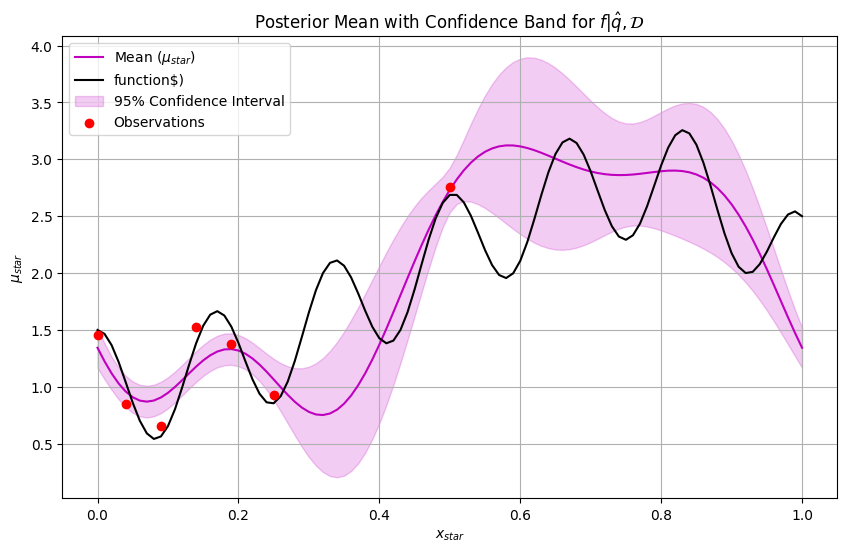

0.8615197741811397


In [35]:
import matplotlib.pyplot as plt
# observations
x_obs = torch.tensor([0,0.25,0.5,0.09,0.14,0.19,0.04])
y_obs = torch.tensor([1.46,0.93,2.76,0.6592,1.528,1.38,0.85])

# Parameters and X* grid
l = 101
q_hat = 2
x_star = torch.linspace(0, 1, l) 

# weights
w = torch.zeros(l)
w[0] = 1 / (2 * (l - 1))
w[-1] = 1 / (2 * (l - 1))
w[1:-1] = 1 / (l - 1)
w = w[:, np.newaxis]

# Kernel for X
K = gp.kernels.Periodic(input_dim=1)(x_star)
K.period = 0.2
K.length_scale = 0.2544
K.variance = 4.4632

# means and covariances 
mu_fq = K @ w * q_hat / (w.T @ K @ w)
cov_fq = K - (K @ w @ w.T @ K) / (w.T @ K @ w)
mu_y = mu_fq[[0,25,50,10,15,20,5]]
cov_fq_marg = torch.tensor([[cov_fq[0,0],cov_fq[0,25],cov_fq[0,50],cov_fq[0,10],cov_fq[0,15],cov_fq[0,20],cov_fq[0,5]],
                      [cov_fq[25,0],cov_fq[25,25],cov_fq[25,50],cov_fq[25,10],cov_fq[25,15],cov_fq[25,20],cov_fq[25,5]],
                      [cov_fq[50,0],cov_fq[50,25],cov_fq[50,50],cov_fq[50,10],cov_fq[50,15],cov_fq[50,20],cov_fq[50,5]],
                      [cov_fq[10,0],cov_fq[10,25],cov_fq[10,50],cov_fq[10,10],cov_fq[10,15],cov_fq[10,20],cov_fq[10,5]],
                      [cov_fq[15,0],cov_fq[15,25],cov_fq[15,50],cov_fq[15,10],cov_fq[15,15],cov_fq[15,20],cov_fq[15,5]],
                      [cov_fq[20,0],cov_fq[20,25],cov_fq[20,50],cov_fq[20,10],cov_fq[20,15],cov_fq[20,20],cov_fq[20,5]],
                      [cov_fq[5,0],cov_fq[5,25],cov_fq[5,50],cov_fq[5,10],cov_fq[5,15],cov_fq[5,20],cov_fq[5,5]]])
noise_y = 0.01
cov_y = cov_fq_marg + noise_y * torch.eye(y_obs.shape[0])
cov_cross = cov_fq[[0, 25, 50,10,15,20,5]]

# mean and covariance of f*|y,X,q̂
mu_star = mu_fq + cov_cross.T @ torch.linalg.inv(cov_y) @ (y_obs.reshape(mu_y.shape)-mu_y)
cov_star = cov_fq - cov_cross.T @ torch.linalg.inv(cov_y) @ cov_cross

# Convert stuff to numpy format
mu_star = mu_star.detach().numpy().flatten()
std_star = torch.sqrt(torch.diagonal(cov_star)).detach().numpy()
x_star = x_star.detach().numpy()
x_obs = x_obs.detach().numpy()
y_obs = y_obs.detach().numpy()

# Plot
g_values = -np.sin(6*np.pi*x_star)**2+6*x_star**2-5*x_star**4+3/2
plt.figure(figsize=(10, 6))
plt.plot(x_star, mu_star, label="Mean ($\mu_{star}$)", color="m")
plt.plot(x_star, g_values, label="function$)", color="black")
plt.fill_between(
    x_star,
    mu_star - 2 * std_star,
    mu_star + 2 * std_star,
    color="m",
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.scatter(x_obs, y_obs, color="red", label="Observations", zorder=5)
plt.xlabel("$x_{star}$")
plt.ylabel("$\mu_{star}$")
plt.title("Posterior Mean with Confidence Band for $f|\hat{q},\\mathcal{D}$")
plt.legend()
plt.grid(True)
plt.show()
y_obs2 = g_values+0.01*np.random.normal(size=101)
print(y_obs2[5])

<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
/var/folders/sw/1gvr93k571d_qm62645m3t5m0000gn/T/ipykernel_49783/3777867195.py:49: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_star, mu_star, label="Mean ($\mu_{star}$)", color="m")
/var/folders/sw/1gvr93k571d_qm62645m3t5m0000gn/T/ipykernel_49783/3777867195.py:50: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_star, g_values, label="Mean ($\mu_{star}$)", color="black")
/var/folders/sw/1gvr93k571d_qm62645m3t5m0000gn/T/ipykernel_49783/3777867195.py:61: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu_{star}$")


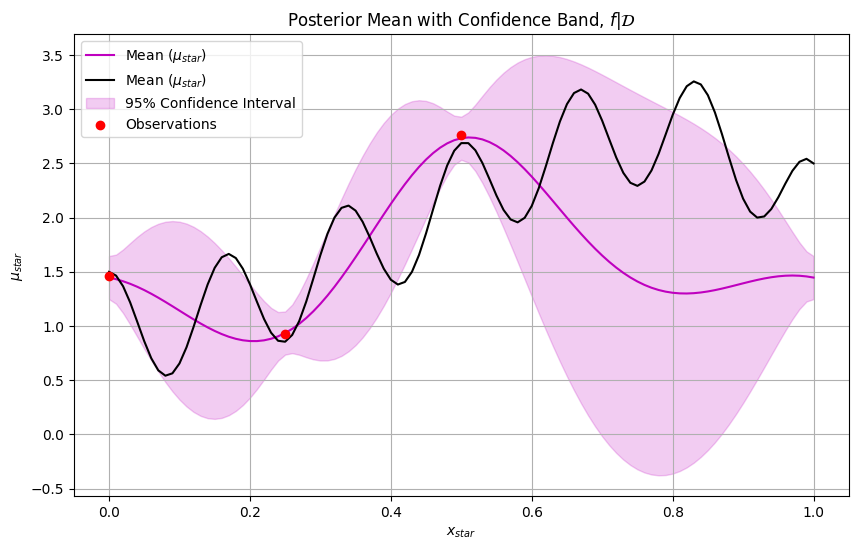

tensor([[ 0.0099,  0.0098,  0.0096,  ...,  0.0100,  0.0100,  0.0099],
        [ 0.0098,  0.0128,  0.0157,  ...,  0.0034,  0.0066,  0.0098],
        [ 0.0096,  0.0157,  0.0215,  ..., -0.0029,  0.0034,  0.0096],
        ...,
        [ 0.0100,  0.0034, -0.0029,  ...,  0.0235,  0.0167,  0.0100],
        [ 0.0100,  0.0066,  0.0034,  ...,  0.0167,  0.0133,  0.0100],
        [ 0.0099,  0.0098,  0.0096,  ...,  0.0100,  0.0100,  0.0099]],
       grad_fn=<SubBackward0>)


In [ ]:
import matplotlib.pyplot as plt
# observations
x_obs = torch.tensor([0,0.25,0.5])
y_obs = torch.tensor([1.46,0.93,2.76])

# Parameters and X* grid
l = 101
q_hat = 2
x_star = torch.linspace(0, 1, l) 

# weights
w = torch.zeros(l)
w[0] = 1 / (2 * (l - 1))
w[-1] = 1 / (2 * (l - 1))
w[1:-1] = 1 / (l - 1)
w = w[:, np.newaxis]

# Kernel for X
K = gp.kernels.Periodic(input_dim=1)(x_star)
K.period = 0.2
K.length_scale = 0.2544
K.variance = 4.4632

# means and covariances 
mu_f = torch.zeros(l)
cov_f = K
mu_y = mu_f[[0,25,50]]
cov_f_marg = torch.tensor([[cov_f[0,0],cov_f[0,25],cov_f[0,50]],
                      [cov_f[25,0],cov_f[25,25],cov_f[25,50]],
                      [cov_f[50,0],cov_f[50,25],cov_f[50,50]]])
noise_y = 0.01
cov_y = cov_f_marg + noise_y * torch.eye(y_obs.shape[0])
cov_cross = cov_f[[0, 25, 50]]

# mean and covariance of f*|y,X,q̂
mu_star = mu_f + cov_cross.T @ torch.linalg.inv(cov_y) @ (y_obs.reshape(mu_y.shape)-mu_y)
cov_star = cov_f - cov_cross.T @ torch.linalg.inv(cov_y) @ cov_cross

# Convert stuff to numpy format
mu_star = mu_star.detach().numpy().flatten()
std_star = torch.sqrt(torch.diagonal(cov_star)).detach().numpy()
x_star = x_star.detach().numpy()
x_obs = x_obs.detach().numpy()
y_obs = y_obs.detach().numpy()

# Plot
g_values = -np.sin(6*np.pi*x_star)**2+6*x_star**2-5*x_star**4+3/2
plt.figure(figsize=(10, 6))
plt.plot(x_star, mu_star, label="Mean ($\mu_{star}$)", color="m")
plt.plot(x_star, g_values, label="Mean ($\mu_{star}$)", color="black")
plt.fill_between(
    x_star,
    mu_star - 2 * std_star,
    mu_star + 2 * std_star,
    color="m",
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.scatter(x_obs, y_obs, color="red", label="Observations", zorder=5)
plt.xlabel("$x_{star}$")
plt.ylabel("$\mu_{star}$")
plt.title("Posterior Mean with Confidence Band, $f|\\mathcal{D}$")
plt.legend()
plt.grid(True)
plt.show()

<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:76: SyntaxWarning: invalid escape sequence '\m'
<>:82: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:76: SyntaxWarning: invalid escape sequence '\m'
<>:82: SyntaxWarning: invalid escape sequence '\m'
/var/folders/sw/1gvr93k571d_qm62645m3t5m0000gn/T/ipykernel_49783/1741805723.py:64: SyntaxWarning: invalid escape sequence '\m'
  axs[0].plot(x_star, mu_star_fq, label="Mean ($\mu_{star}$)", color="m")
/var/folders/sw/1gvr93k571d_qm62645m3t5m0000gn/T/ipykernel_49783/1741805723.py:76: SyntaxWarning: invalid escape sequence '\m'
  axs[0].set_ylabel("$\mu_{star}$")
/var/folders/sw/1gvr93k571d_qm62645m3t5m0000gn/T/ipykernel_49783/1741805723.py:82: SyntaxWarning: invalid escape sequence '\m'
  axs[1].plot(x_star, mu_star_f, label="Mean ($\mu_{star}$)", color="m")


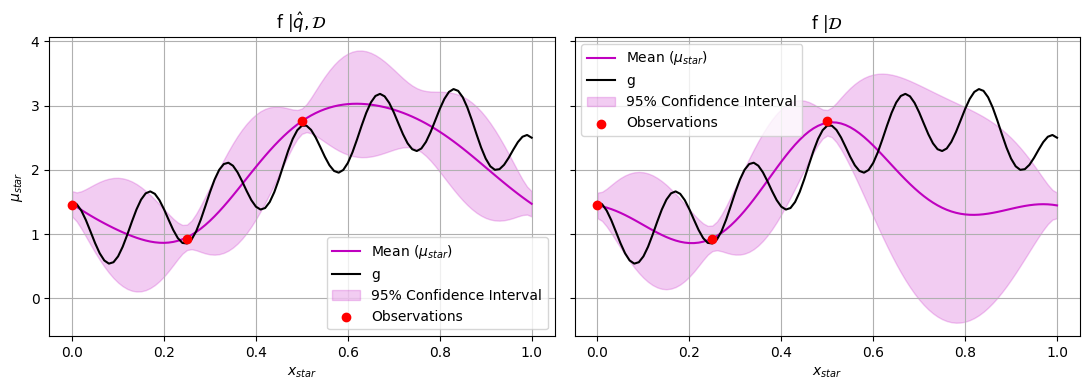

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro.contrib.gp as gp

# Common setup for both plots
x_obs = torch.tensor([0, 0.25, 0.5])
y_obs = torch.tensor([1.46, 0.93, 2.76])
l = 101
q_hat = 2
x_star = torch.linspace(0, 1, l)
w = torch.zeros(l)
w[0] = 1 / (2 * (l - 1))
w[-1] = 1 / (2 * (l - 1))
w[1:-1] = 1 / (l - 1)
w = w[:, np.newaxis]

K = gp.kernels.Periodic(input_dim=1)(x_star)
K.period = 0.2
K.lengthscale = 0.2544
K.variance = 4.4632

# First plot setup (Posterior with q̂)
mu_fq = K @ w * q_hat / (w.T @ K @ w)
cov_fq = K - (K @ w @ w.T @ K) / (w.T @ K @ w)
mu_y_fq = mu_fq[[0, 25, 50]]
cov_fq_marg = torch.tensor([[cov_fq[0, 0], cov_fq[0, 25], cov_fq[0, 50]],
                            [cov_fq[25, 0], cov_fq[25, 25], cov_fq[25, 50]],
                            [cov_fq[50, 0], cov_fq[50, 25], cov_fq[50, 50]]])
noise_y = 0.01
cov_y_fq = cov_fq_marg + noise_y * torch.eye(y_obs.shape[0])
cov_cross_fq = cov_fq[[0, 25, 50]]
mu_star_fq = mu_fq + cov_cross_fq.T @ torch.linalg.inv(cov_y_fq) @ (y_obs.reshape(mu_y_fq.shape) - mu_y_fq)
cov_star_fq = cov_fq - cov_cross_fq.T @ torch.linalg.inv(cov_y_fq) @ cov_cross_fq

mu_star_fq = mu_star_fq.detach().numpy().flatten()
std_star_fq = torch.sqrt(torch.diagonal(cov_star_fq)).detach().numpy()

# Second plot setup (Posterior without q̂)
mu_f = torch.zeros(l)
cov_f = K
mu_y_f = mu_f[[0, 25, 50]]
cov_f_marg = torch.tensor([[cov_f[0, 0], cov_f[0, 25], cov_f[0, 50]],
                           [cov_f[25, 0], cov_f[25, 25], cov_f[25, 50]],
                           [cov_f[50, 0], cov_f[50, 25], cov_f[50, 50]]])
cov_y_f = cov_f_marg + noise_y * torch.eye(y_obs.shape[0])
cov_cross_f = cov_f[[0, 25, 50]]
mu_star_f = mu_f + cov_cross_f.T @ torch.linalg.inv(cov_y_f) @ (y_obs.reshape(mu_y_f.shape) - mu_y_f)
cov_star_f = cov_f - cov_cross_f.T @ torch.linalg.inv(cov_y_f) @ cov_cross_f

mu_star_f = mu_star_f.detach().numpy().flatten()
std_star_f = torch.sqrt(torch.diagonal(cov_star_f)).detach().numpy()

# Prepare common values for plotting
x_star = x_star.detach().numpy()
x_obs = x_obs.detach().numpy()
y_obs = y_obs.detach().numpy()
g_values = -np.sin(6 * np.pi * x_star) ** 2 + 6 * x_star ** 2 - 5 * x_star ** 4 + 3 / 2

# Plot both subplots
fig, axs = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

# First subplot
axs[0].plot(x_star, mu_star_fq, label="Mean ($\mu_{star}$)", color="m")
axs[0].plot(x_star, g_values, label="g", color="black")
axs[0].fill_between(
    x_star,
    mu_star_fq - 2 * std_star_fq,
    mu_star_fq + 2 * std_star_fq,
    color="m",
    alpha=0.2,
    label="95% Confidence Interval",
)
axs[0].scatter(x_obs, y_obs, color="red", label="Observations", zorder=5)
axs[0].set_xlabel("$x_{star}$")
axs[0].set_ylabel("$\mu_{star}$")
axs[0].set_title("f $\\vert\\hat{q},\\mathcal{D}$")
axs[0].legend()
axs[0].grid(True)

# Second subplot
axs[1].plot(x_star, mu_star_f, label="Mean ($\mu_{star}$)", color="m")
axs[1].plot(x_star, g_values, label="g", color="black")
axs[1].fill_between(
    x_star,
    mu_star_f - 2 * std_star_f,
    mu_star_f + 2 * std_star_f,
    color="m",
    alpha=0.2,
    label="95% Confidence Interval",
)
axs[1].scatter(x_obs, y_obs, color="red", label="Observations", zorder=5)
axs[1].set_xlabel("$x_{star}$")
axs[1].set_title("f $\\vert\\mathcal{D}$")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
